In [1]:
# Import libraries
import json
import pandas as pd
import gzip
import math
from datetime import datetime

# Graphing
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# Doc2vec
from gensim.models import doc2vec
from collections import namedtuple
from datetime import datetime
import re
import string
from sklearn import utils
from sklearn.model_selection import train_test_split
#import cPickle as pickle

# Hide warnings
import warnings
warnings.filterwarnings('ignore')
# ==================================================================================================

In [2]:
# Load review data
# This file contains reviews for all categories in Cell Phone Electronics within the one-year time frame
reviews = pd.read_csv('/Users/yujinglai/Downloads/reviews_asin.csv')
reviews.drop(reviews.columns[0], axis=1, inplace=True) # Drop index column

def numImg(x): 
    if (type(x) is str):
        return x.count(',')
    return 0

def numVote(x):
    if (type(x) is str):
        return float(int(x.replace(',', '')))
    if (math.isnan(x)):
        return 0
    return x

# Process reviews
reviews['image'] = reviews['image'].apply(numImg) # Add image count
reviews['vote'] = reviews['vote'].apply(numVote) # Add vote count
reviews['reviewTime'] = reviews['reviewTime'].apply(lambda x: str(datetime.strptime(x, '%m %d, %Y').date()))


In [12]:
# Remove asin with less than 10 reviews
reviews['review_count'] = reviews.groupby('asin')['asin'].transform('count') # Count reviews/asin
reviews = reviews.loc[reviews['review_count'] > 10]

In [14]:
# Learning resources:
# https://stackoverflow.com/questions/31321209/doc2vec-how-to-get-document-vectors
# https://radimrehurek.com/gensim/models/doc2vec.html
# https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4

# ==================================================================================================

# Load data from path 
#df = pd.read_csv('/Users/yujinglai/Documents/Reviews2019/data/doc2vec_7/arslan-reviews2.csv', low_memory=False)

# Drop all columns except for item_id and text
item_id = 'asin'
text_col = 'reviewText'
df = reviews[[item_id, text_col]]

# Drop records with empty reviews
df = df[pd.notnull(df[text_col])]

In [15]:
# Clean text
from bs4 import BeautifulSoup
def cleanText(text):
    soup = BeautifulSoup(text, "lxml")
    text = soup.get_text() # Remove url
    text = "".join([c for c in text if c not in string.punctuation]) # Remove punctuation
    text = text.lower() # To lower case
    return text

startTime = datetime.now() # Time that script started running
df[text_col] = df[text_col].apply(cleanText)
print(datetime.now() - startTime) # Time it took script to run

0:12:36.106752


In [9]:
# ==================================================================================================
def tokenize_text(texts, ids):
    tokens = []
    # Organize data (assign each review a tag 0 to i)
    analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
    for i, text in enumerate(texts):
        words = text.split()
        #tags = [ids[i]]
        tags = [i]
        tokens.append(analyzedDocument(words, tags))
    return tokens

In [ ]:
# Split training(7/10), test (3/10) dataset
train, test = train_test_split(df, test_size=0.3, random_state=42)

# Generate list of item ids and review texts 
ids = list(df[item_id])
texts = list(df[text_col])
train_ids = list(train[item_id])
train_texts = list(train[text_col])
test_ids = list(test[item_id])
test_texts = list(test[text_col])

# Tokenize texts
train_corpus = tokenize_text(train_texts, train_ids)
test_corpus = tokenize_text(test_texts, test_ids)

In [36]:
# Train the model
model = doc2vec.Doc2Vec(vector_size = 100, min_count=2, epochs=10)
model.build_vocab(train_corpus)
startTime = datetime.now() # Time that script started running
model.train(train_corpus, total_examples = model.corpus_count, epochs = model.epochs)
print(datetime.now() - startTime) # Time it took script to run

0:02:01.885357


In [41]:
# Assessing the model
import random
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(test_corpus) - 1)
inferred_vector = model.infer_vector(doc_words = test_corpus[doc_id].words)
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

# Compare and print the most/median/least similar documents from the train corpus
print('Test Document ({}): «{}»\n'.format(test_corpus[doc_id][1], ' '.join(test_corpus[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Test Document ([78893]): «great charger good compact size still works after it fell out of my pocket and got chewed up by the snow blower only plastic end caps broke would buy again very durable»

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d100,n5,w5,mc2,s0.001,t3):

MOST (151169, 0.5517106056213379): «great»

MEDIAN (55030, 0.22467494010925293): «much better products available i have blown through both screens 2 provided in package in a short period of time the feel of the glass is good and smooth cleaning it up from smudges and dirt and grime is easy i am not hard on my phone but found this protect broke at the slightest impact and the adherence to the glass of the phone was problematic as it did adhere around the edges well 1 star for the glass 1 for the low price i am buying a different manufacture next time»

LEAST (46698, -0.303036630153656): «niceirno»



In [16]:
# ==================================================================================================
ids = list(df[item_id])
texts = list(df[text_col])

# Input all reviews
train_corpus = tokenize_text(texts, ids)

# Train the model
model = doc2vec.Doc2Vec(vector_size = 100, min_count=2)
model.build_vocab(train_corpus)
startTime = datetime.now() # Time that script started running
model.train(train_corpus, total_examples = model.corpus_count, epochs = model.epochs)
print(datetime.now() - startTime) # Time it took script to run

0:15:56.777310


In [17]:
# Assessing the model
import random
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(train_corpus) - 1)
inferred_vector = model.infer_vector(doc_words = train_corpus[doc_id].words)
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

# Compare and print the most/median/least similar documents from the train corpus
print('Test Document ({}): «{}»\n'.format(train_corpus[doc_id].tags, ' '.join(train_corpus[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Test Document ([1052646]): «perfect for traveling i bought this power bank for a travel to japan during the trip i left the hotel early in the morning and returned late at night and had it on my backpack all the time charging my cellphone my camera a portable wifi device without the need to connect it to power for 23 days in a row it is a little heavy but it is worth it to have charge for all your devices whenever you need them another good thing is that it does not get hot when charging compared to other portable batteries i have owned due to its high capacity it takes some time to get charged so my recommendation is to plug it before going to sleep and check it as soon as you wake up»

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d100,n5,w5,mc2,s0.001,t3):

MOST (1153695, 0.5802326202392578): «met all expectations for recharge applications cord is of good quality and easy to coil for storage i would recommend for purchase»

MEDIAN (561456, 0.12627407908439636): «i ordered this for 

In [18]:
# Create a dictionary with key value pair (Product ID : List of review vector values)
final_dict = {}
for i in range(len(ids)):
    if ids[i] in final_dict:
        final_dict[ids[i]].append(model.docvecs[i])
    else:
        new_list = []
        new_list.append(model.docvecs[i])
        final_dict[ids[i]] = new_list

In [19]:
# Find mean of values and update dictionary to reflect new values 
for key in final_dict.keys():
    current_list = final_dict[key]
    vector_avg = sum(current_list)/len(current_list)
    final_dict[key] = vector_avg

In [20]:
# Write dictionary to Pandas dataframe
vectors = pd.DataFrame.from_dict(final_dict, orient = 'index')
#vectors.to_csv('julien_vectors.csv')

In [7]:
vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
8288878881,-0.001301,0.043438,-0.021425,0.022332,-0.018625,-0.019440,0.029104,-0.046165,-0.038056,0.018094,...,0.069609,0.034096,-0.021621,-0.021642,0.010608,-0.012038,-0.025346,-0.022125,0.044015,0.033138
9638762918,-0.000862,0.057537,-0.021205,0.055027,-0.041491,-0.035040,0.030459,-0.093126,-0.062656,0.022506,...,0.106453,0.048026,-0.027606,-0.028858,0.023098,0.010221,-0.020498,-0.055742,0.074432,0.030843
9638762632,0.014102,0.062637,-0.043580,0.059192,-0.041081,-0.044546,0.033389,-0.073598,-0.049230,-0.000484,...,0.114438,0.048697,-0.015071,-0.015552,0.019992,-0.009119,-0.023522,-0.066941,0.071139,0.032729
9678315173,-0.002911,0.052743,-0.023313,0.047230,-0.026158,-0.035186,0.023528,-0.072954,-0.057203,0.026606,...,0.103089,0.045490,-0.023857,-0.024685,0.019463,-0.002182,-0.019131,-0.049865,0.083714,0.045454
9713957334,-0.006684,0.058535,-0.013864,0.041131,-0.024932,-0.027182,0.028574,-0.063848,-0.034979,0.013868,...,0.089043,0.037169,-0.020594,-0.019888,0.008063,0.007780,-0.020687,-0.039803,0.069674,0.036748


In [22]:
# Generate cosine similarity matrix from vectors
from sklearn.metrics.pairwise import cosine_similarity

def make_sims(vectors):
    sims = cosine_similarity(vectors)
    sims = pd.DataFrame(sims)
    sims.index = vectors.index
    sims.columns = vectors.index
    return sims

In [ ]:
sims = make_sims(vectors)
sims.head()

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

In [ ]:
def plot_map(sims):
    mask = np.zeros_like(sims, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        ax = sns.heatmap(sims, mask=mask, linewidth=0.5, square=True,  cmap="YlGnBu")
        plt.show()

plot_map(sims.iloc[0:19,0:19])

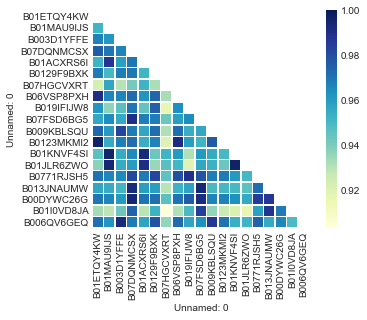

In [52]:
vectors2 = pd.read_csv('/Users/yujinglai/Documents/Reviews2019/data/doc2vec_7/vector.csv', index_col=0, low_memory=False)
sims2 = make_sims(vectors2)
plot_map(sims2.iloc[0:19,0:19])

In [64]:
reviews = []
review = namedtuple('Review', 'tags asin vector')
for i in range(len(ids)):
    reviews.append(review(i, ids[i], model.docvecs[i]))

In [65]:
df_reviews = pd.DataFrame(reviews, columns=['tag', 'asin', 'vector'])

In [66]:
df_reviews.head()

,tag,asin,vector
0,0,B00DYWC26G,"[0.000984267, -0.08318225, -0.006825556, 0.031..."
1,1,B00DYWC26G,"[-0.00028309147, -0.14773747, 0.009544687, 0.0..."
2,2,B00K4DTTLY,"[-0.0735937, -0.12629165, -0.007716434, 0.0660..."
3,3,B00SE9CM78,"[-0.014608441, -0.06531299, -0.07525114, 0.072..."
4,4,B00SQY0M1Y,"[-0.08744975, -0.016986296, -0.19692673, 0.103..."
